In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy
import json

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import GResNet,EDense
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist,mnist
from keras.layers import Dense
from keras.models import Model
from keras.utils import to_categorical
from src.metrics import var_expl,norm_var_expl
import argparse
# from tabulate import tabulate

Using TensorFlow backend.


In [2]:
def load_config(model_dir):
    fp = os.path.join(model_dir,'params.json')
    print('loading...',fp)
    with open(fp, 'r') as f:
        json_config = json.load(f)
        config = argparse.Namespace()
        for k in json_config.keys():
            setattr(config, k, json_config[k])
        return config

In [3]:
model_dir = '/home/elijahc/projects/vae/logs/mnist_1101_230859'
config = load_config(model_dir)

loading... /home/elijahc/projects/vae/logs/mnist_1101_230859/params.json


In [4]:
vars(config)

{'batch_size': 512,
 'data_dir': 'data',
 'dataset': 'mnist',
 'dec_blocks': [4, 2, 1],
 'dev_mode': False,
 'enc_layers': [3000, 2000],
 'epochs': 100,
 'log_dir': '../logs',
 'log_level': 'INFO',
 'max_translation': 0.9,
 'min_delta': 0.5,
 'model_dir': '../logs/mnist_1101_230859',
 'model_name': 'mnist_1101_235004',
 'monitor': 'val_G_loss',
 'optimizer': 'adam',
 'recon': 5,
 'xcov': 1000,
 'xent': 10,
 'y_dim': 10,
 'z_dim': 10}

In [5]:
sweep = argparse.Namespace()
setattr(sweep, 'dxs', [])
setattr(sweep, 'dys', [])
setattr(sweep, 'z_enc', [])
setattr(sweep, 'class_enc',[])
setattr(sweep, 'history',[])


for tx_val in [0.0,0.15,0.3,0.5,0.7,0.9]:
    dxs_fp = os.path.join(model_dir,'dxs_tr'+str(tx_val)+'.npy')
    dys_fp = os.path.join(model_dir,'dys_tr'+str(tx_val)+'.npy')
    z_enc_fp = os.path.join(model_dir,'z_enc_tr'+str(tx_val)+'.npy')
    class_enc_fp = os.path.join(model_dir,'class_enc_tr'+str(tx_val)+'.npy')
    hist_fp = os.path.join(model_dir,'tx_{}training_hist.pk'.format(str(tx_val)))
    sweep.dxs.append(np.load(dxs_fp))
    sweep.dys.append(np.load(dys_fp))
    sweep.z_enc.append(np.load(z_enc_fp))
    sweep.class_enc.append(np.load(class_enc_fp))
    sweep.history.append(pd.read_pickle(hist_fp))
    
sweep.fve_dx = [norm_var_expl(features=z_enc,cond=dxs,bins=15) for z_enc,dxs in zip(sweep.z_enc,sweep.dxs)]
sweep.fve_dy = [norm_var_expl(features=z_enc,cond=dys,bins=15) for z_enc,dys in zip(sweep.z_enc,sweep.dys)]   

/home/elijahc/projects/vae/notebooks/src/metrics.py:28: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num((cond.var()-fve)/np.nan_to_num(cond.var()))
/home/elijahc/projects/vae/notebooks/src/metrics.py:21: RuntimeWarning: Degrees of freedom <= 0 for slice
  Z_cond_var[j,i] = cond[np.where(Z_bin_idx[:,i]==j)[0]].var()
/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
sweep.history[0].head()

,D_loss,G_loss,G_mse,class_acc,class_loss,loss,val_D_loss,val_G_loss,val_G_mse,val_class_acc,val_class_loss,val_loss
0,1.139984,139.068113,139.068113,0.331491,2.098376,719.759101,1.597446,54.622852,54.622852,0.685667,1.310713,287.485206
1,1.287343,49.537220,49.537220,0.746158,0.891239,257.464461,1.058364,45.479911,45.479911,0.877000,0.513749,234.239469
2,0.980862,38.534771,38.534771,0.863895,0.486269,198.378162,0.981630,35.805501,35.805501,0.911667,0.325780,183.153742
3,0.914691,33.495218,33.495218,0.894561,0.375632,172.441367,0.799872,33.270592,33.270592,0.941000,0.267131,170.122935
4,0.811408,29.958677,29.958677,0.913035,0.331153,153.814376,0.809304,29.174839,29.174839,0.947000,0.236599,148.630172


(array([2564.,    0.,    0., 2431.,    0.,    0., 2495.,    0.,    0.,
        2510.]),
 array([-2. , -1.7, -1.4, -1.1, -0.8, -0.5, -0.2,  0.1,  0.4,  0.7,  1. ]),
 <a list of 10 Patch objects>)

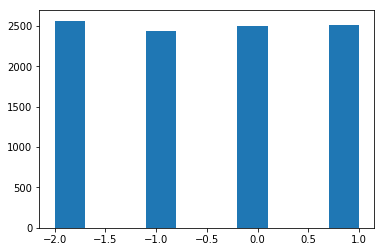

In [7]:
plt.hist(sweep.dys[1])

In [45]:
from src.plot import *

def plot_sweep_history(saga,key=None):
    num_iter = len(saga)
    
    fig,axs = plt.subplots(1,num_iter,sharey=True,figsize=(2*num_iter,3))
    for ax,dat in zip(axs,saga):
        plot_train_history(dat,key=key,ax=ax)
        plot_train_history(dat,key='val_'+key,ax=ax)
        ax.legend([key,'val_'+key])
#         ax.title('a')

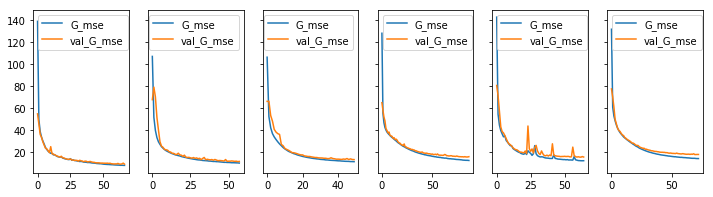

In [46]:
plot_sweep_history(sweep.history,key='G_mse')

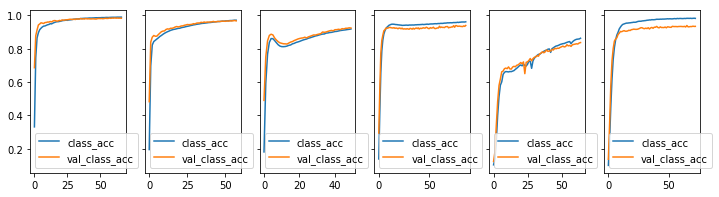

In [47]:
plot_sweep_history(sweep.history,key='class_acc')

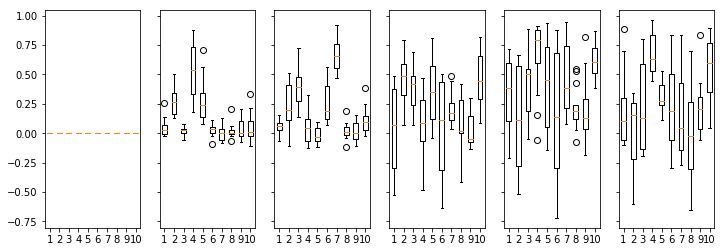

In [10]:
def plot_sweep(dataset):
    num_iter = len(dataset)
    
    fig,axs = plt.subplots(1,num_iter,sharey=True,figsize=(2*num_iter,4))

    for ax,dat in zip(axs,dataset):
        ax.boxplot(dat)

plot_sweep([fve for fve in sweep.fve_dx])

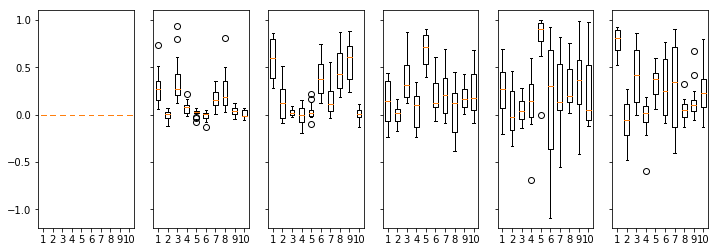

In [11]:
plot_sweep([fve for fve in sweep.fve_dy])

(-9, 9)

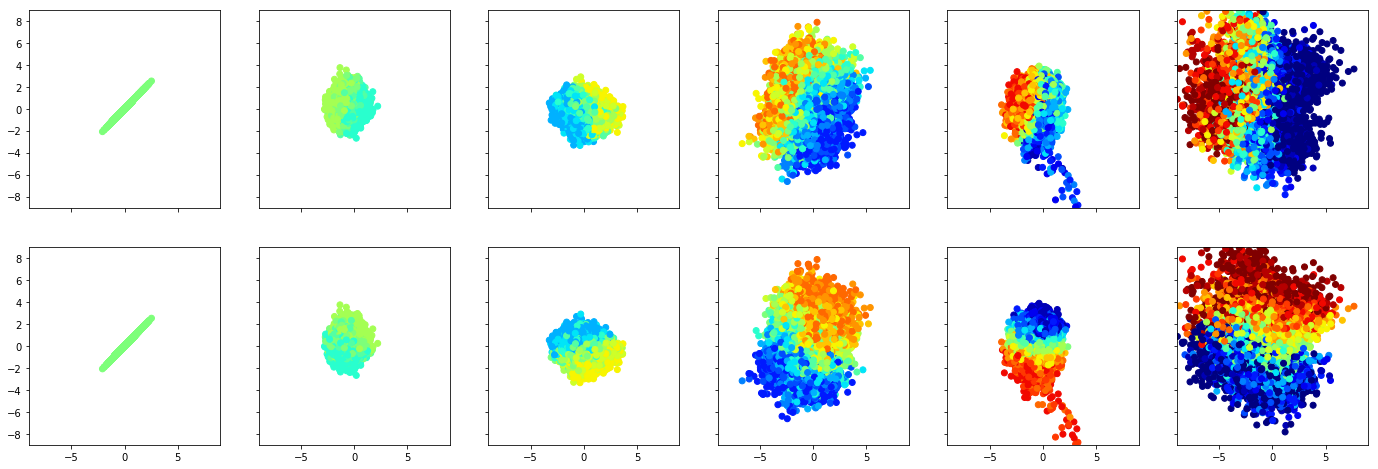

In [44]:
xdim = [np.argmax(fve.mean(axis=0)) for fve in sweep.fve_dx]
ydim = [np.argmax(fve.mean(axis=0)) for fve in sweep.fve_dy]
def plot_cplot(xdim,ydim,z_enc,color_x, color_y):
    num_iter = len(z_enc)
    
    fig,axs = plt.subplots(2,num_iter,sharey=True,sharex=True,figsize=(4*num_iter,8))
    
    for ax,z,x,y,cx in zip(axs[0],z_enc,xdim,ydim,color_x):
        ax.scatter(z[:,x],z[:,y],c=cx,vmin=-10,vmax=10,cmap='jet')
    for ax,z,x,y,cy in zip(axs[1],z_enc,xdim,ydim,color_y):
        im = ax.scatter(z[:,x],z[:,y],c=cy,vmin=-10,vmax=10,cmap='jet')
        
#     fig.subplots_adjust(right=0.8)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 2])
#     fig.colorbar(im, cax=cbar_ax)

plot_cplot(xdim,ydim,sweep.z_enc,sweep.dxs,sweep.dys)
plt.ylim(-9,9)
plt.xlim(-9,9)

In [43]:
plot_cplot(xdim,ydim,sweep.z_enc,sweep.dys)
plt.ylim(-9,9)
plt.xlim(-9,9)

TypeError: plot_cplot() missing 1 required positional argument: 'color_y'